In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn import linear_model
from sklearn.feature_selection import RFE

logistic_regression = linear_model.LogisticRegression()

/usr/local/Cellar/python3/3.6.4_2/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Load data files

In [3]:
waves = pd.read_csv('../binary/Wavelength.csv', header=None)
x = pd.read_csv('../binary/X.csv', header=None)
y = pd.read_csv('../binary/y.csv', header=None)

### Set up plot parameters

In [55]:
def plot_parameters(x, y):
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = x
    fig_size[1] = y
    plt.rcParams["figure.figsize"] = fig_size

plot_parameters(30, 10)

In [5]:
x.describe()

,0,1,2,3,4,5,6,7,8,9,...,911,912,913,914,915,916,917,918,919,920
count,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,...,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000
mean,-7.285778,26.623167,-39.141444,31.432056,19.583389,-27.309889,-1.363278,16.758222,-1.462556,20.104333,...,17.075222,-0.391444,6.723667,-10.397389,6.965833,-17.164222,2.614111,-0.534778,7.659167,27.403722
std,28.066784,38.301483,38.125418,16.871401,19.078221,25.123531,28.830671,24.518862,24.424941,22.169355,...,24.204869,27.783458,32.377364,34.395392,35.424993,42.765649,33.565696,30.336068,23.692330,20.522360
min,-74.140000,-92.590000,-143.410000,-13.050000,-25.910000,-87.240000,-72.790000,-64.190000,-79.430000,-44.400000,...,-25.340000,-45.670000,-50.880000,-70.100000,-64.090000,-92.670000,-59.460000,-55.220000,-37.350000,-12.100000
25%,-24.740000,2.035000,-63.590000,19.257500,6.325000,-41.460000,-20.357500,2.350000,-15.630000,5.200000,...,-4.470000,-24.952500,-23.310000,-44.620000,-25.830000,-59.050000,-26.330000,-27.592500,-13.342500,8.255000
50%,-8.725000,28.960000,-35.035000,31.315000,18.445000,-27.265000,-1.695000,16.980000,0.300000,19.925000,...,19.210000,-5.640000,4.385000,-10.635000,5.745000,-18.400000,-2.005000,0.430000,8.120000,29.080000
75%,11.212500,52.927500,-12.890000,44.292500,34.950000,-8.497500,19.560000,35.207500,14.840000,33.822500,...,38.465000,25.162500,36.692500,21.817500,39.475000,20.445000,32.507500,26.692500,29.067500,45.830000
max,71.960000,145.480000,58.810000,72.410000,66.890000,47.220000,82.840000,79.350000,71.910000,75.150000,...,63.680000,48.820000,66.170000,57.770000,71.210000,56.550000,68.440000,62.360000,47.640000,65.770000


### Drop records with NaN values if any exists

In [6]:
# Drop all rows that have NaN values
def drop_nan(waves, x, y):
    waves.dropna()
    x.dropna()
    y.dropna()
    
drop_nan(waves, x, y)

### Split data into training and testing sets 

In [122]:
flat_waves = waves.T.as_matrix(columns=None).flatten()
x_train, x_test, y_train, y_test  = train_test_split(x, y, test_size=0.3, random_state=42)

print(x_train.size, y_train.size)
print(x_test.size, y_test.size)

116046 126
49734 54


In [123]:
y_train = y_train.as_matrix(columns=None)

### Plot all features

In [124]:
def plot_features(x_train, waves):
    index = 0
    for ind, row in x_train.iterrows():
        if y_train[index] == 1:
            plt.plot(waves, row, color="indianred")
        else:
            plt.plot(waves, row, color="lightgreen")
        index += 1

    plt.xlabel("Wave length", fontdict=None, labelpad=None, fontsize=12)
    plt.ylabel("Optical reflectance intensity", fontdict=None, labelpad=None, fontsize=12)
    plt.yticks([-150, -100, -50, 0, 50, 100, 150], fontsize=12)  
    plt.xticks(fontsize=12)  

    # plt.axvspan(650, 650, color='grey', alpha=0.5)

    plt.show()

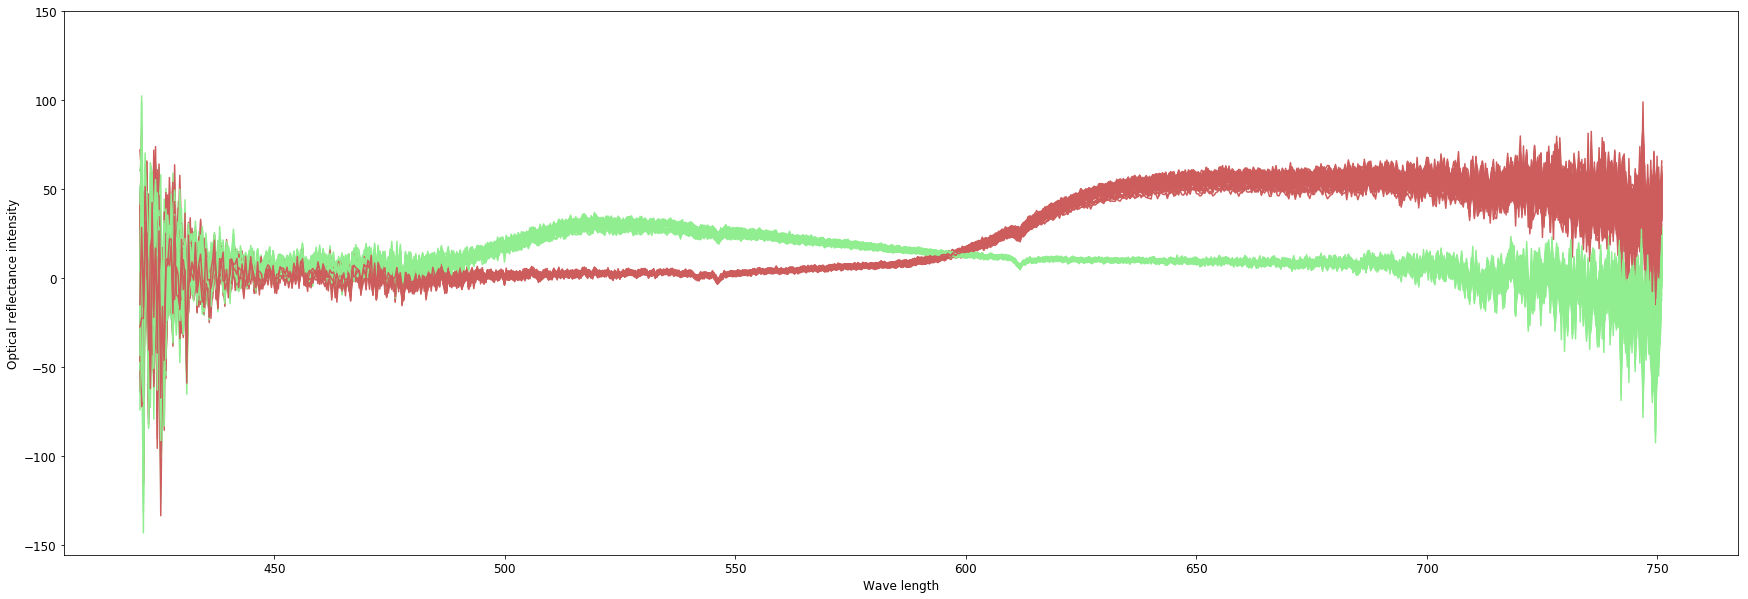

In [125]:
plot_features(x_train, flat_waves)

In [11]:
def get_true_indices(matrix):
    indices = []
    index = 0
    for i in matrix:
        if i == True:
            indices.append(index)
        index += 1
    return indices

### One feature experiment
It trains on a single feature using logistic regression model and plots accuracy. In return, this indicates which single features have
best accuracy and thus should be chosen. 

In [129]:
def one_feature_experiment(x_train, y_train):
    accuracies = []
    
    for i in x_train:
        x_one = x_train[i].values.reshape(-1, 1)
        logistic_regression.fit(x_one, y_train.ravel())
        y_res = logistic_regression.predict(x_one)
        accuracies.append(accuracy_score(y_train, y_res))

    return accuracies

In [217]:
def plot_one_feature_exp_results(acc):
    plot_parameters(30, 10)
    plt.xlabel("Feature index", fontdict=None, labelpad=None, fontsize=12)
    plt.ylabel("Accuracy", fontdict=None, labelpad=None, fontsize=12)
    plt.yticks(fontsize=12)
    plt.xticks([0, 100, 200, 300, 400, 500, 600, 700, 800, 900], fontsize=12)  
    plt.xlim(xmin=0, xmax=921)
    
    index = 0
    for i in acc:
        if i == 1:
            plt.axvspan(index, index+1, color='pink', alpha=0.8)
        elif i > 0.9:
            plt.axvspan(index, index, color='pink', alpha=0.6)
        elif i > 0.8:
            plt.axvspan(index, index, color='pink', alpha=0.4)
        elif i > 0.7:
            plt.axvspan(index, index, color='pink', alpha=0.2)
        elif i > 0.6:
            plt.axvspan(index, index, color='pink', alpha=0.1)
        elif i > 0.5:
            plt.axvspan(index, index, color='pink', alpha=0.05)

        index += 1
        
    plt.plot(acc)

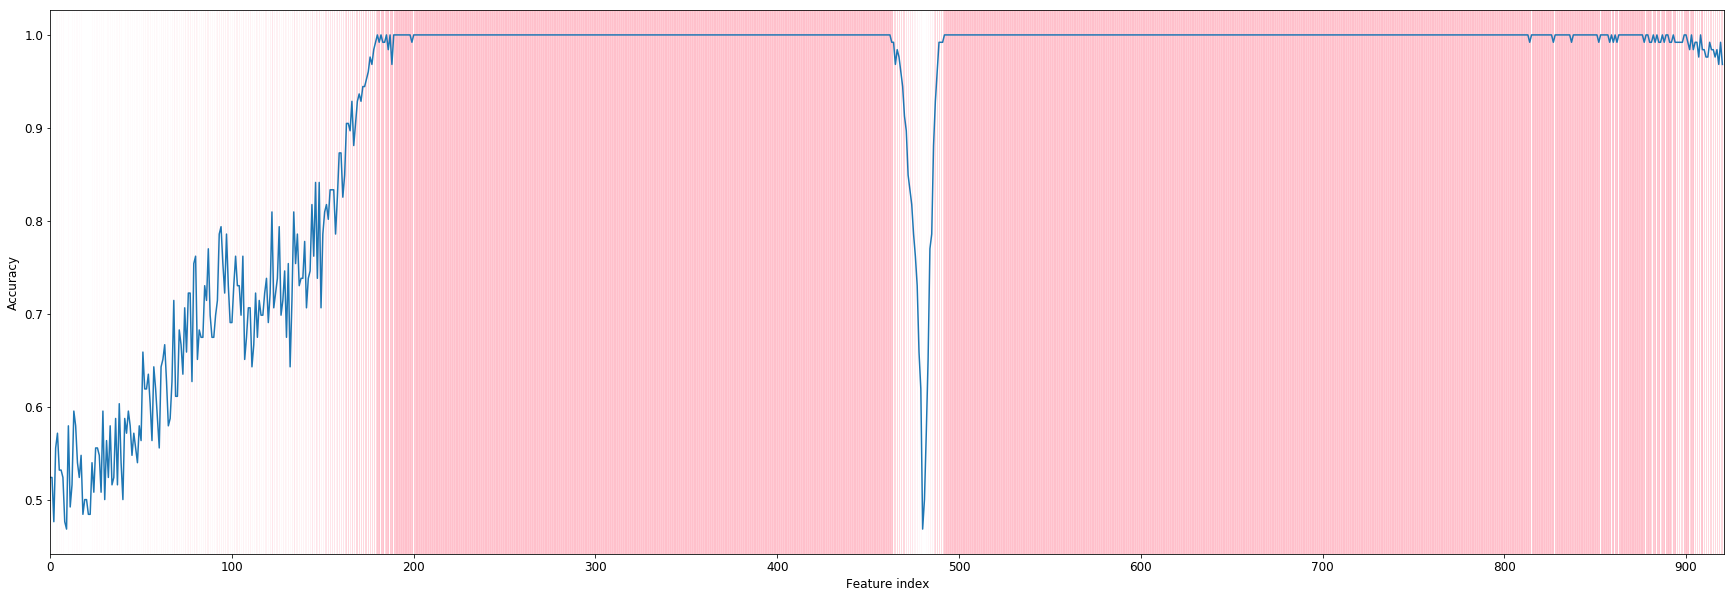

In [218]:
acc = one_feature_experiment(x_train, y_train)
plot_one_feature_exp_results(acc)

In [126]:
# def get_wave_values(waves, indices):
#     values = []
    
#     for i in indices:
#         print(i)
#         values.append(waves.iloc[[i]])
            
#     return values
# get_wave_values(waves, indices)

In [64]:
def get_waves_index(df, value):
    for idx, row in df.iterrows():
        if row[0] == value:
            return idx
        
feature_index = get_waves_index(waves, 650.411)

In [65]:
feature_index

629

In [66]:
x_train_one_feature = x_train[629]
x_train_one_feature = x_train_one_feature.values.reshape(-1, 1)

In [67]:
logistic_regression.fit(x_train_one_feature, y_train.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [68]:
y_res = logistic_regression.predict(x_train_one_feature)
accuracy_score(y_train, y_res)

1.0

### Plots confussion matrix for results

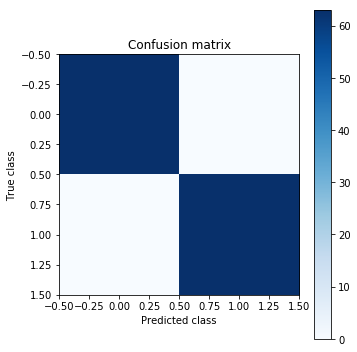

In [127]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
#     tick_marks = np.arange(len(iris.target_names))
#     plt.xticks(tick_marks, iris.target_names, rotation=45)
#     plt.yticks(tick_marks, iris.target_names)
    plt.tight_layout()
    plt.ylabel('True class')
    plt.xlabel('Predicted class')

plot_parameters(5, 5)
# Compute confusion matrix
cm = confusion_matrix(y_train, y_res)
np.set_printoptions(precision=1)
# print('Confusion matrix, without normalization')
# print(cm)
# plt.figure()
plot_confusion_matrix(cm)

In [70]:
x_test_one_feature = x_test[629]
x_test_one_feature = x_test_one_feature.values.reshape(-1, 1)
y_res_test = logistic_regression.predict(x_test_one_feature)
accuracy_score(y_test, y_res_test)


1.0

In [128]:
# indices = get_true_indices(selector.support_)
# indices
# x_train[indices[0]]
# waves.iloc[[indices[0]]]